In [1]:
import pandas as pd
import torch
from chronos import BaseChronosPipeline
import tqdm as notebook_tqdm

import numpy as np
import pandas as pd

import Utils 
from Utils import calculateEMA, calculateBB, addPreviousDays, removeColumns, getPeriod, mape, mae, createDate, getDate, printResult

import matplotlib.pyplot as plt
import matplotlib.dates as mpdates
import mplfinance as mpf
from mplfinance.original_flavor import candlestick_ohlc

import warnings
warnings.filterwarnings('ignore')
import pdb
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer

c:\Users\Rodrigo\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dfColumns = ['date','open', 'high', 'low','close','tickvol','volume','spread']
newColumns = ['open', 'high', 'low', 'close']
col15 = ['open','d-5_high','d-5_low','d-4_high','d-4_low','d-3_high','d-3_low','d-2_high','d-2_low','d-1_high','d-1_low','EMA_high','EMA_low','UB_close','LB_close']
col25 = ['open','d-5_open','d-5_high','d-5_low','d-5_close','d-4_open','d-4_high','d-4_low','d-4_close','d-3_open','d-3_high','d-3_low','d-3_close','d-2_open','d-2_high','d-2_low','d-2_close','d-1_open','d-1_high','d-1_low','d-1_close','EMA_high' ,'EMA_low','UB_close','LB_close']
DAYS = 5
TEST_BEGIN = '2021.04.06'
TEST_END = '2021.06.01'
TRAIN_BEGIN = '2018.03.30'
TRAIN_END = '2021.04.05'
TIMES = 10

In [3]:
def create_df(fundo):
    df = pd.read_csv(f'../Data/{fundo}_Daily.csv', sep = "\t")
    df.columns = dfColumns
    df = removeColumns(df, ['tickvol', 'volume','spread'])
    #df = calculateEMA(df,DAYS,newColumns)
    #df = calculateBB(df,DAYS,newColumns)
    df = addPreviousDays(df,DAYS, newColumns)
    initialDf_ = getPeriod(df, '2017.06.01','2021.06.01', True)
    return initialDf_

**Fine tuning?**

In [9]:
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

In [17]:
def getTrainDf(df_train, target_col='high'):
    removed_col = 'low' if target_col == 'high' else 'high'

    df_train = df_train.copy()
    df_train['item_id'] = 'ASSET'
    df_train = df_train.drop([removed_col, 'close'], axis=1)
    df_train = df_train.rename(columns={'date': 'timestamp'})
    df_train.columns = [col for col in df_train.columns]
    return TimeSeriesDataFrame(df_train)

In [18]:
def getTestDf(df):
    df_test = df.copy()
    df_test['item_id'] = 'ASSET'
    df_test = df_test.drop(['high', 'low', 'close'], axis=1)
    df_test = df_test.rename(columns={'date': 'timestamp'})
    df_test.columns = [col for col in df_test.columns]

    return TimeSeriesDataFrame(df_test)


In [19]:
def fixHoliday(df):
    df_ts = df.reset_index()
    nova_linha = df_ts.iloc[10]
    nova_linha['timestamp'] = pd.Timestamp('2021-04-21')
    df_ts = pd.concat([df_ts.iloc[:11], pd.DataFrame([nova_linha]), df_ts.iloc[11:]], ignore_index=True)
    return TimeSeriesDataFrame(df_ts)

In [20]:
def generatePredictor(df, target_col='high', normalizer='', 
                train_start='2018.04.02', train_end='2021.02.03',
                valid_start='2021.02.04', valid_end='2021.04.05',
                test_start='2021.04.06', test_end='2021.06.01',
                prediction_length=41):

    df_train = getPeriod(df, train_start, train_end)
    df_valid = getPeriod(df, valid_start, valid_end)

    train_df = getTrainDf(pd.concat([df_train, df_valid]), target_col=target_col)

    predictor = TimeSeriesPredictor(
        prediction_length=prediction_length,
        target=target_col,
        known_covariates_names=[col for col in train_df.columns if col not in ['item_id', 'timestamp', target_col]],
        freq="B"
    ).fit(
        train_df,
        hyperparameters={
            "Chronos": [
                {
                    "model_path": "bolt_small",
                    "covariate_regressor": "CAT",
                    "target_scaler": "standard",
                    "ag_args": {"name_suffix": "WithRegressor"},
                },
            ],
        },
        enable_ensemble=False,
        time_limit=None,
    )

    return predictor
           

In [21]:
def exp_chronos_with_finetuning(df, predictor, target_col='high', normalizer='', 
                train_start='2018.04.02', train_end='2021.02.03',
                valid_start='2021.02.04', valid_end='2021.04.05',
                test_start='2021.04.06', test_end='2021.06.01'):
    
    df_train = getPeriod(df, train_start, train_end)
    df_valid = getPeriod(df, valid_start, valid_end)
    df_test  = getPeriod(df, test_start, test_end)

    y_test  = df_test[target_col].values

    inputDf = getTrainDf(pd.concat([df_train, df_valid]), target_col=target_col)
    covariates_df = getTestDf(df_test)
    covariates_df = fixHoliday(covariates_df)   
    forecast = predictor.predict(inputDf, known_covariates=covariates_df)

    #4.Resultados
    y_pred_mean = forecast['mean']
    y_test_orig = y_test[-40:]
    q10 = forecast['0.1']
    q90 = forecast['0.9']
    uncertainty = q90 - q10


    return [y_test_orig, y_pred_mean, uncertainty]

In [26]:
def generatePlot(y_test_orig, y_pred_mean, uncertainty, target_col, fundo): 
    # Criar eixo de tempo
    dias = np.arange(len(y_test_orig))

    # Calcular faixa de incerteza (intervalo 90% - 10%)
    inferior = y_pred_mean - (uncertainty / 2)
    superior = y_pred_mean + (uncertainty / 2)

    plt.figure(figsize=(10, 6))

    # Linha real (azul)
    plt.plot(dias, y_test_orig, label='Valor Real', color='blue', marker='o')

    # Linha prevista (laranja)
    plt.plot(dias, y_pred_mean, label='Previsão Média', color='red', marker='o')

    # Faixa de incerteza (sombreada)
    plt.fill_between(dias, inferior, superior, color='orange', alpha=0.3, label='Incerteza (10%-90%)')

    # Rótulos e legendas
    plt.title(f'Previsão com Chronos vs Valor Real {fundo}')
    plt.xlabel('Dias')
    plt.ylabel('Preço (' + target_col + ')')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [27]:
def runPrediction(fundo):
    df = create_df(fundo)

    high_predictor = generatePredictor(df, prediction_length=41, target_col='high')
    low_predictor = generatePredictor(df, prediction_length=41, target_col='low')

    orig_high, pred_high, uncertainty_high = exp_chronos_with_finetuning(df, high_predictor, target_col='high')
    pred_high = pred_high.drop(pred_high.index[11])
    uncertainty_high = uncertainty_high.drop(uncertainty_high.index[11])

    orig_low, pred_low, uncertainty_low = exp_chronos_with_finetuning(df, low_predictor, target_col='low')
    pred_low = pred_low.drop(pred_low.index[11])
    uncertainty_low = uncertainty_low.drop(uncertainty_low.index[11])

    return [orig_high, pred_high, uncertainty_high, orig_low, pred_low, uncertainty_low]
    

Beginning AutoGluon training...
AutoGluon will save models to 'c:\Users\Rodrigo\Desktop\TCC\Code\DayTradeSystem\DayTradeSystem\Rodrigo\AutogluonModels\ag-20250610_212428'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.10.11
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          8
GPU Count:          0
Memory Avail:       18.45 GB / 31.94 GB (57.8%)
Disk Space Avail:   222.22 GB / 446.38 GB (49.8%)

Fitting with arguments:
{'enable_ensemble': False,
 'eval_metric': WQL,
 'freq': 'B',
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'WithRegressor'},
                                  'covariate_regressor': 'CAT',
                                  'model_path': 'bolt_small',
                                  'target_scaler': 'standard'}]},
 'known_covariates_names': ['open',
                            'd-1_open',
                            'd-1_high',
                      

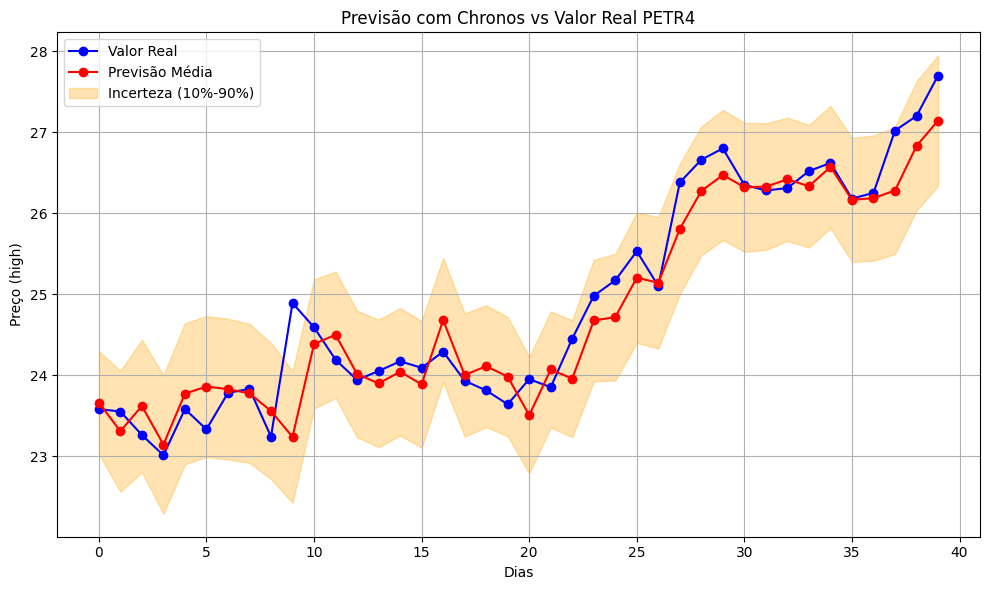

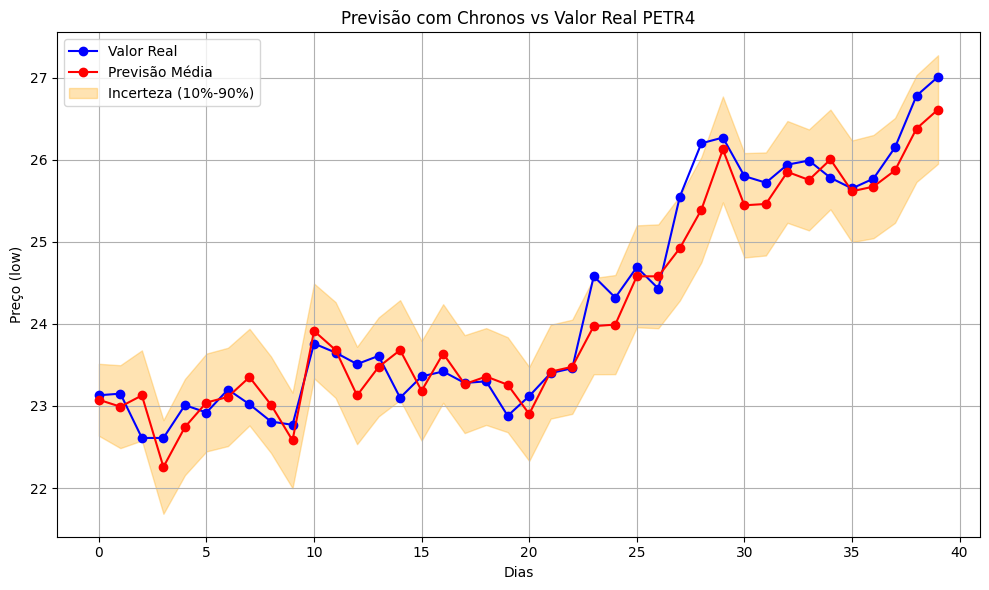

Beginning AutoGluon training...
AutoGluon will save models to 'c:\Users\Rodrigo\Desktop\TCC\Code\DayTradeSystem\DayTradeSystem\Rodrigo\AutogluonModels\ag-20250610_212653'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.10.11
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          8
GPU Count:          0
Memory Avail:       16.67 GB / 31.94 GB (52.2%)
Disk Space Avail:   222.22 GB / 446.38 GB (49.8%)

Fitting with arguments:
{'enable_ensemble': False,
 'eval_metric': WQL,
 'freq': 'B',
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'WithRegressor'},
                                  'covariate_regressor': 'CAT',
                                  'model_path': 'bolt_small',
                                  'target_scaler': 'standard'}]},
 'known_covariates_names': ['open',
                            'd-1_open',
                            'd-1_high',
                      

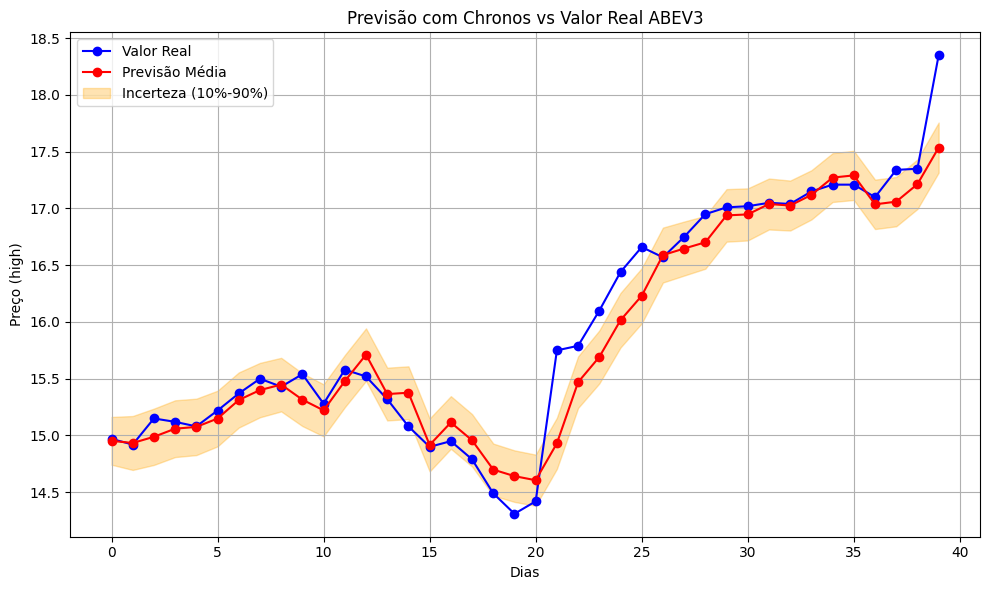

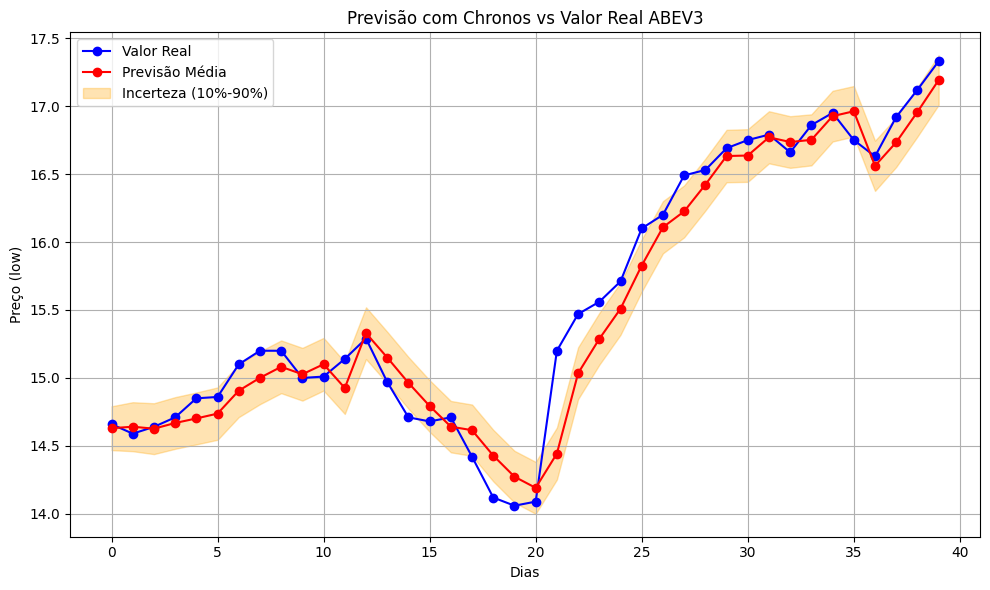

Beginning AutoGluon training...
AutoGluon will save models to 'c:\Users\Rodrigo\Desktop\TCC\Code\DayTradeSystem\DayTradeSystem\Rodrigo\AutogluonModels\ag-20250610_212731'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.10.11
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          8
GPU Count:          0
Memory Avail:       16.73 GB / 31.94 GB (52.4%)
Disk Space Avail:   222.22 GB / 446.38 GB (49.8%)

Fitting with arguments:
{'enable_ensemble': False,
 'eval_metric': WQL,
 'freq': 'B',
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'WithRegressor'},
                                  'covariate_regressor': 'CAT',
                                  'model_path': 'bolt_small',
                                  'target_scaler': 'standard'}]},
 'known_covariates_names': ['open',
                            'd-1_open',
                            'd-1_high',
                      

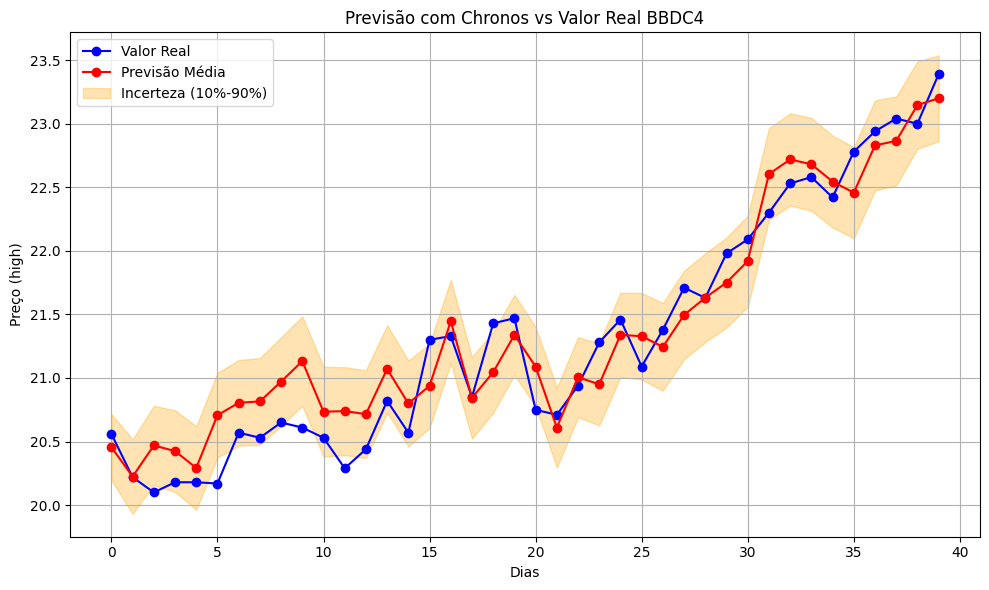

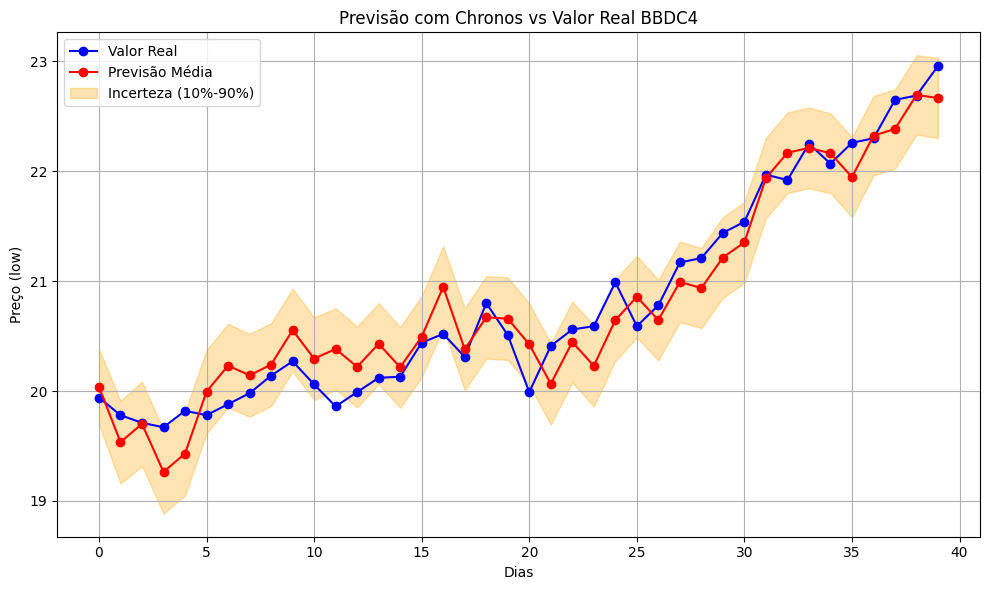

Beginning AutoGluon training...
AutoGluon will save models to 'c:\Users\Rodrigo\Desktop\TCC\Code\DayTradeSystem\DayTradeSystem\Rodrigo\AutogluonModels\ag-20250610_212817'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.10.11
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          8
GPU Count:          0
Memory Avail:       16.69 GB / 31.94 GB (52.3%)
Disk Space Avail:   222.21 GB / 446.38 GB (49.8%)

Fitting with arguments:
{'enable_ensemble': False,
 'eval_metric': WQL,
 'freq': 'B',
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'WithRegressor'},
                                  'covariate_regressor': 'CAT',
                                  'model_path': 'bolt_small',
                                  'target_scaler': 'standard'}]},
 'known_covariates_names': ['open',
                            'd-1_open',
                            'd-1_high',
                      

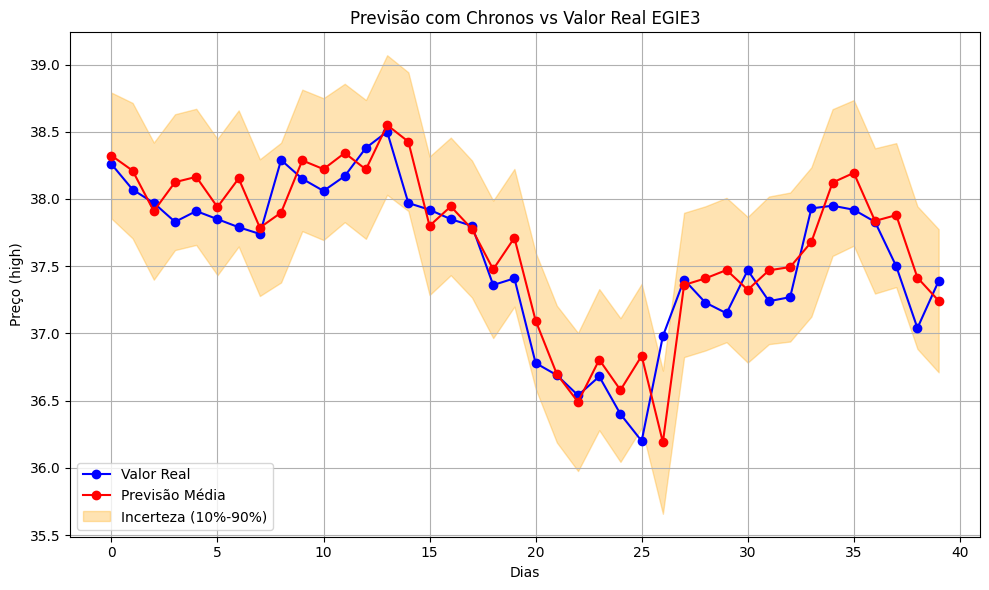

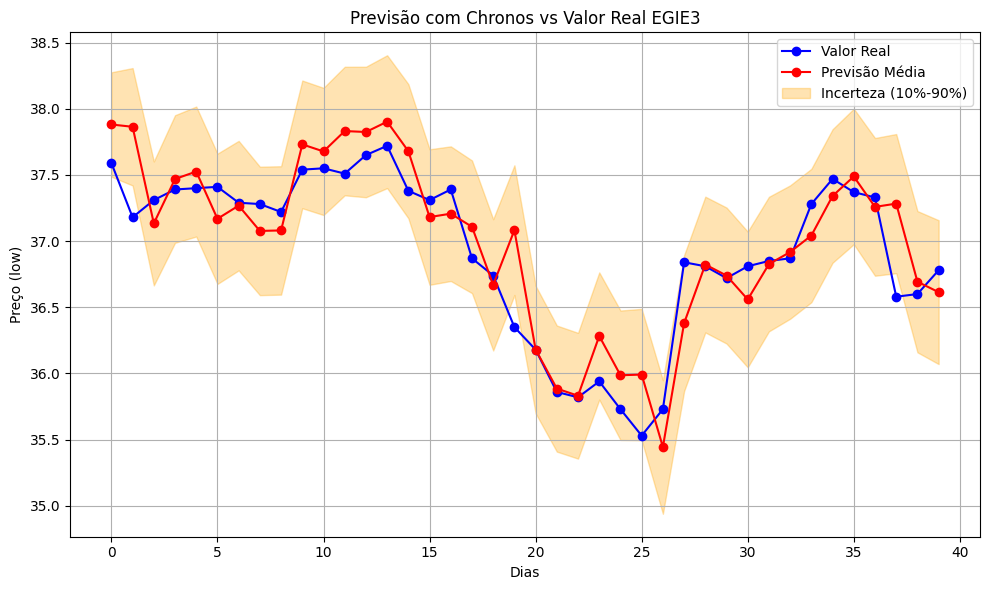

Beginning AutoGluon training...
AutoGluon will save models to 'c:\Users\Rodrigo\Desktop\TCC\Code\DayTradeSystem\DayTradeSystem\Rodrigo\AutogluonModels\ag-20250610_212932'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.10.11
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          8
GPU Count:          0
Memory Avail:       16.52 GB / 31.94 GB (51.7%)
Disk Space Avail:   222.21 GB / 446.38 GB (49.8%)

Fitting with arguments:
{'enable_ensemble': False,
 'eval_metric': WQL,
 'freq': 'B',
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'WithRegressor'},
                                  'covariate_regressor': 'CAT',
                                  'model_path': 'bolt_small',
                                  'target_scaler': 'standard'}]},
 'known_covariates_names': ['open',
                            'd-1_open',
                            'd-1_high',
                      

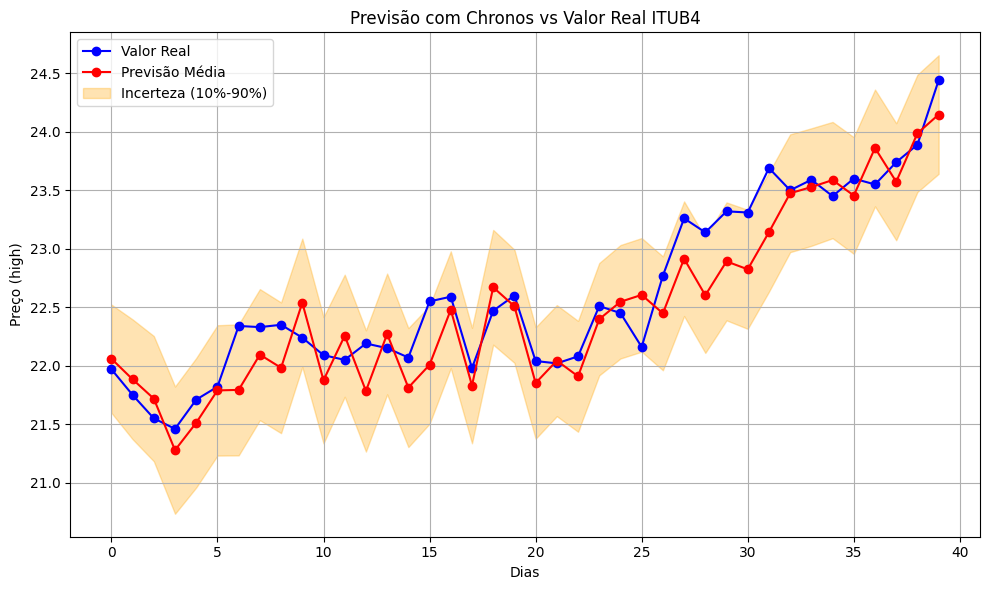

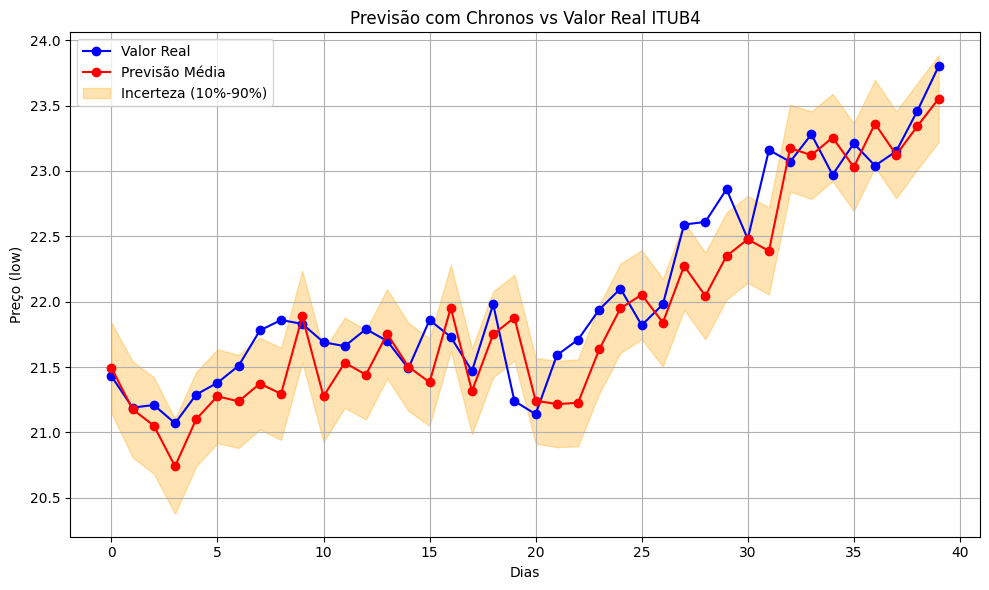

Beginning AutoGluon training...
AutoGluon will save models to 'c:\Users\Rodrigo\Desktop\TCC\Code\DayTradeSystem\DayTradeSystem\Rodrigo\AutogluonModels\ag-20250610_213128'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.10.11
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          8
GPU Count:          0
Memory Avail:       16.55 GB / 31.94 GB (51.8%)
Disk Space Avail:   222.21 GB / 446.38 GB (49.8%)

Fitting with arguments:
{'enable_ensemble': False,
 'eval_metric': WQL,
 'freq': 'B',
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'WithRegressor'},
                                  'covariate_regressor': 'CAT',
                                  'model_path': 'bolt_small',
                                  'target_scaler': 'standard'}]},
 'known_covariates_names': ['open',
                            'd-1_open',
                            'd-1_high',
                      

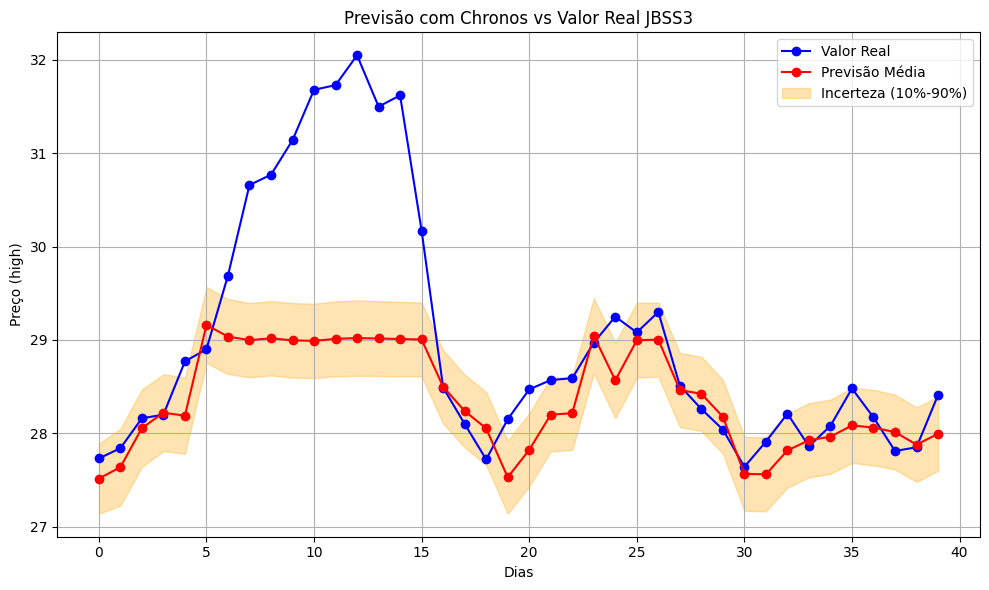

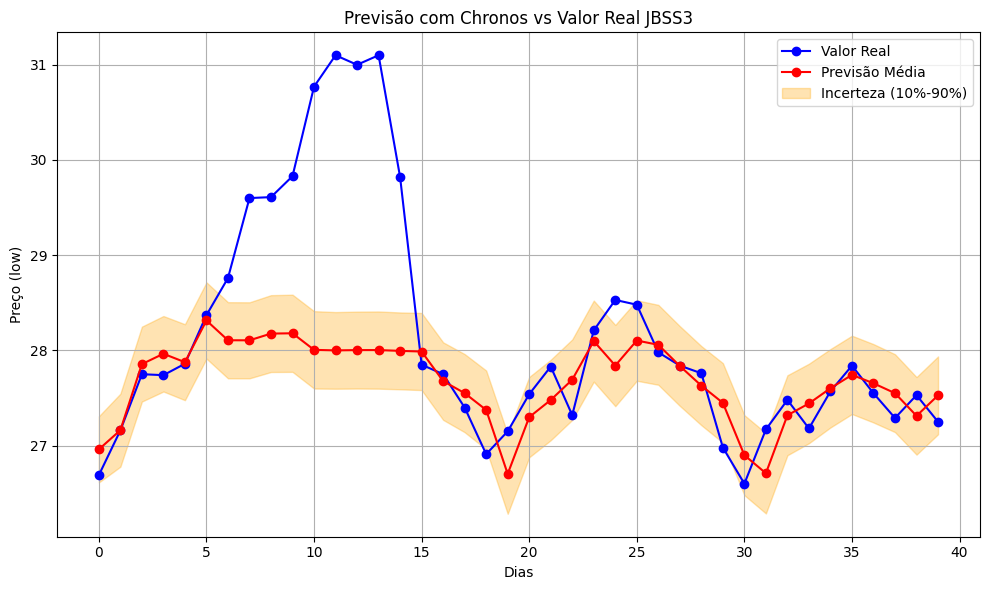

Beginning AutoGluon training...
AutoGluon will save models to 'c:\Users\Rodrigo\Desktop\TCC\Code\DayTradeSystem\DayTradeSystem\Rodrigo\AutogluonModels\ag-20250610_213201'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.10.11
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          8
GPU Count:          0
Memory Avail:       16.70 GB / 31.94 GB (52.3%)
Disk Space Avail:   222.21 GB / 446.38 GB (49.8%)

Fitting with arguments:
{'enable_ensemble': False,
 'eval_metric': WQL,
 'freq': 'B',
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'WithRegressor'},
                                  'covariate_regressor': 'CAT',
                                  'model_path': 'bolt_small',
                                  'target_scaler': 'standard'}]},
 'known_covariates_names': ['open',
                            'd-1_open',
                            'd-1_high',
                      

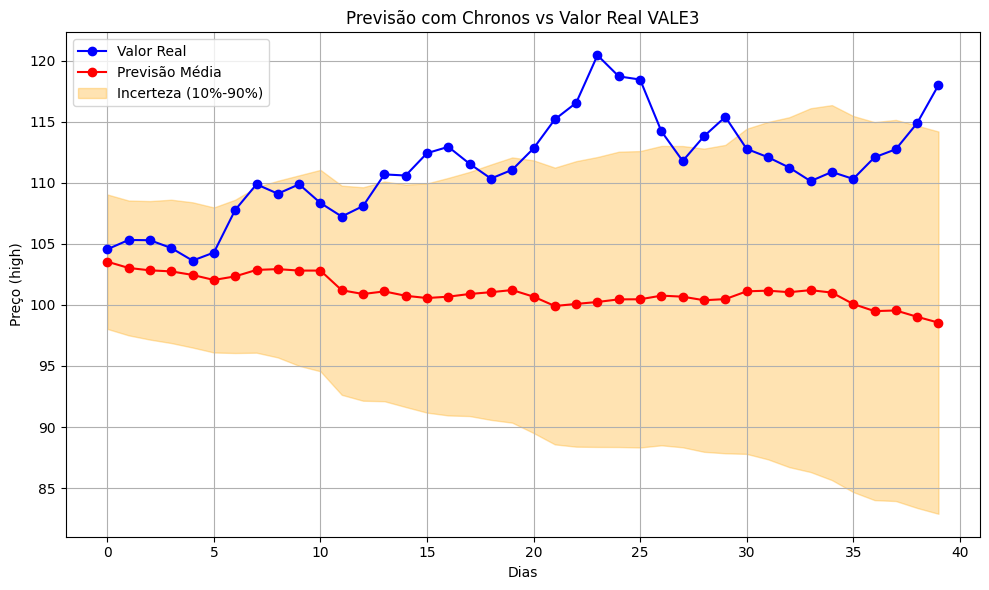

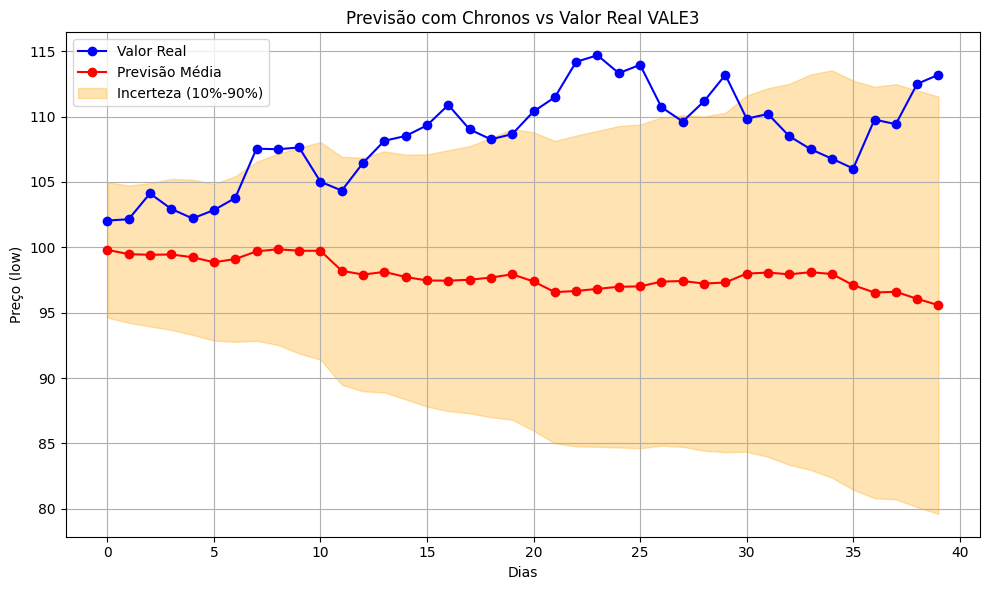

In [28]:
fundos = ['PETR4', 'ABEV3', 'BBDC4', 'EGIE3', 'ITUB4', 'JBSS3', 'VALE3']
for name in fundos:
    orig_high, pred_high, uncertainty_high, orig_low, pred_low, uncertainty_low = runPrediction(name)

    generatePlot(orig_high, pred_high, uncertainty_high, 'high', name)
    generatePlot(orig_low, pred_low, uncertainty_low, 'low', name)

    result_prediction = pd.DataFrame()
    result_prediction['high_pred'] = pred_high
    result_prediction['low_pred'] = pred_low
    result_prediction['uncertainty_high'] = uncertainty_high
    result_prediction['uncertainty_low'] = uncertainty_low
    result_prediction['uncertainty_mean'] = (result_prediction['uncertainty_high'] + result_prediction['uncertainty_low']) / 2
    #result_prediction['uncertainty_valid_mean'] = (f[:,0] + f[:,1]) / 2
    result_prediction['high'] = orig_high
    result_prediction['low'] = orig_low
    result_prediction.to_pickle(f'../Data/{name}_Pred.pkl')
    result_prediction.tail(10)

In [29]:
pred_PETR4 = pd.read_pickle('../Data/ABEV3_Pred.pkl')
pred_PETR4 = pred_PETR4.reset_index()
pred_PETR4

,item_id,timestamp,high_pred,low_pred,uncertainty_high,uncertainty_low,uncertainty_mean,high,low
0,ASSET,2021-04-06,14.952989,14.630005,0.420668,0.322286,0.371477,14.97,14.66
1,ASSET,2021-04-07,14.933817,14.641156,0.475090,0.360454,0.417772,14.92,14.59
2,ASSET,2021-04-08,14.988503,14.626554,0.496156,0.374112,0.435134,15.15,14.64
3,ASSET,2021-04-09,15.059850,14.668490,0.500221,0.380292,0.440257,15.12,14.71
4,ASSET,2021-04-12,15.075702,14.701956,0.497167,0.381842,0.439505,15.08,14.85
5,ASSET,2021-04-13,15.149243,14.737449,0.490144,0.385193,0.437668,15.22,14.86
6,ASSET,2021-04-14,15.312494,14.906201,0.485686,0.388964,0.437325,15.37,15.10
7,ASSET,2021-04-15,15.400003,15.000896,0.479340,0.388009,0.433674,15.50,15.20
8,ASSET,2021-04-16,15.448181,15.081767,0.472025,0.387888,0.429956,15.43,15.20
9,ASSET,2021-04-19,15.315485,15.027051,0.465313,0.387963,0.426638,15.54,15.00
